In [62]:
import pandas as pd
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import *
from sklearn.metrics import *
from sklearn.inspection import * 
from utils import *
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import pearsonr
sns.set_style("whitegrid")

In [86]:
def calculate_horizontal_feature_differences(df, variable):
    '''
    Calculate the horizontal potential temperature differences for a given variable and pressure levels.
    '''
    
    df_variable = df.filter(regex=(f"{variable}"))
    
    feature_dict = {}

    variable_list1 = sorted(df_variable.columns.tolist())
    variable_list2 = sorted(df_variable.columns.tolist())

    for col1 in variable_list1:
        variable_list2.remove(col1)
        for col2 in variable_list2:
            feature_dict[f"diff_{col1}_{col2}"] = (df_variable.loc[:, col1] - df_variable.loc[:, col2]).values

    return pd.DataFrame(feature_dict)

def evaluate_regression(y_true, y_pred):
    """
    Automatically evaluate the performance of a regressor (model-agnostic)
    """
    # Calculate maximum range
    min_val, max_val = min(np.min(y_true), np.min(y_pred)), max(np.max(y_true), np.max(y_pred))

    # Prediction density plot
    plt.figure()
    sns.distplot(y_true, kde=True, bins=np.linspace(min_val, max_val, 20))
    sns.distplot(y_pred, kde=True, bins=np.linspace(min_val, max_val, 20), color="orange")
    plt.legend(["True", "Pred"])
    plt.title("Prediction histogram")

    # Scatter plot
    plt.figure()
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([min_val, max_val], [min_val, max_val], "r-")
    plt.axis('square')
    plt.xlabel("True label")
    plt.ylabel("Pred label")

    # Regression metrics
    print('(MAE) Mean absolute error: ', round(mean_absolute_error(y_true, y_pred), 4))
    print('(MSE) Mean squared error: ', round(mean_squared_error(y_true, y_pred), 4))
    print('(RMSE) Root mean squared error: ', round(np.sqrt(mean_squared_error(y_true, y_pred)),4))  # Gives a relatively high weight to large errors (compared to MAE)
    print('(RMSLE) Root mean squared log error: ', round(mean_squared_log_error(y_true, y_pred),4))  # Punishes underprediction harder, robuster towards outliers, also considers a relative error
    #print('(MAPE) Mean absolute percentage error: ', round(mean_absolute_percentage_error(y_true, y_pred), 4))  # sensitive to relative errors, scale-invariant
    print('(MedAE) Median absolute error: ', round(median_absolute_error(y_true, y_pred), 4))  # Robust to outliers
    print('(R2) R2-score: ', round(r2_score(y_true, y_pred), 4))
    print('(EV) Explained_variance: ', round(explained_variance_score(y_true, y_pred), 4))  # Equivalent to R2 if mean error/residuals == 0, otherwise bias in residuals
    print('(CorrCoeff) Correlation Coefficient: ', round(pearsonr(y_true, y_pred)[0], 4)) 

In [64]:
df_foehn = pd.read_csv("/atmosdyn2/chmony/develop/foehn-fire-impact/data/03_primary/foehn_data_prepared.csv")

In [109]:
target="ALT_FFX"

In [110]:
df_strength = df_foehn.loc[df_foehn["ALT_foehn"]==1, :]

In [111]:
target_col = df_strength[target]

In [112]:
df_strength = df_strength.drop(columns=df_foehn.filter(regex="(_foehn|_FF|ALT_|UU)").columns)

In [113]:
df_strength[target] = target_col
df_strength = df_strength.loc[df_strength[target].notnull(), :].reset_index(drop=True)

In [114]:
df_SLP_diff =  calculate_horizontal_feature_differences(df_strength, variable="SLP")
df_Z850_diff =  calculate_horizontal_feature_differences(df_strength, variable="Z850")
df_TT_diff =  calculate_horizontal_feature_differences(df_strength, variable="TT")

In [115]:
df_strength_fe = pd.concat([df_strength, 
                     df_SLP_diff, 
                     df_Z850_diff, 
                     df_TT_diff], 
                    axis = 1)

In [116]:
df_strength_fe

,ABO_DD,AIG_DD,CHU_DD,COM_DD,DAV_DD,EBK_DD,EIN_DD,ELM_DD,ENG_DD,GLA_DD,...,diff_STG_TT_VAD_TT,diff_STG_TT_VIO_TT,diff_STG_TT_VIS_TT,diff_STG_TT_WAE_TT,diff_VAD_TT_VIO_TT,diff_VAD_TT_VIS_TT,diff_VAD_TT_WAE_TT,diff_VIO_TT_VIS_TT,diff_VIO_TT_WAE_TT,diff_VIS_TT_WAE_TT
0,NaN,180.0,174.0,NaN,180.0,NaN,NaN,NaN,NaN,307.0,...,NaN,NaN,NaN,NaN,NaN,-2.1,3.5,NaN,NaN,5.6
1,NaN,180.0,168.0,NaN,204.0,NaN,NaN,NaN,NaN,315.0,...,NaN,NaN,NaN,NaN,NaN,0.0,5.7,NaN,NaN,5.7
2,NaN,256.0,176.0,NaN,90.0,NaN,NaN,NaN,NaN,360.0,...,NaN,NaN,NaN,NaN,NaN,0.3,6.2,NaN,NaN,5.9
3,NaN,14.0,169.0,NaN,0.0,NaN,NaN,NaN,NaN,56.0,...,NaN,NaN,NaN,NaN,NaN,0.3,6.3,NaN,NaN,6.0
4,NaN,297.0,172.0,NaN,360.0,NaN,NaN,NaN,NaN,270.0,...,NaN,NaN,NaN,NaN,NaN,-1.8,4.1,NaN,NaN,5.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103313,30.0,266.0,218.0,167.0,211.0,305.0,270.0,164.0,292.0,317.0,...,-6.5,9.2,2.1,-1.1,15.7,8.6,5.4,-7.1,-10.3,-3.2
103314,28.0,262.0,222.0,239.0,210.0,255.0,269.0,122.0,260.0,313.0,...,-6.4,8.9,1.6,-1.1,15.3,8.0,5.3,-7.3,-10.0,-2.7
103315,205.0,325.0,220.0,244.0,204.0,260.0,267.0,108.0,274.0,323.0,...,-7.1,8.4,0.7,-1.5,15.5,7.8,5.6,-7.7,-9.9,-2.2
103316,233.0,43.0,207.0,323.0,181.0,272.0,281.0,129.0,250.0,320.0,...,-7.2,7.8,0.5,-2.0,15.0,7.7,5.2,-7.3,-9.8,-2.5


In [117]:
df_train, df_test  = train_test_split(df_strength_fe, train_size=0.8)

In [118]:
# Generate aliases for easier readability
X_train = df_train.drop(columns=[target, "date"])
y_train = df_train[target]
X_test = df_test.drop(columns=[target, "date"])
y_test = df_test[target]
final_features = X_train.columns

In [119]:
y_train.isnull().sum()

0

In [120]:
# Here XGBoost Classifier
clf = xgb.XGBRegressor(use_label_encoder=False, verbosity=0, n_estimators=300)

In [121]:
# Fit default classifier
clf.fit(X_train, y_train, verbose=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=56, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             use_label_encoder=False, validate_parameters=1, verbosity=0)

--- Train set ---
(MAE) Mean absolute error:  3.7865
(MSE) Mean squared error:  24.3809
(RMSE) Root mean squared error:  4.9377
(RMSLE) Root mean squared log error:  0.0069
(MedAE) Median absolute error:  3.0072
(R2) R2-score:  0.9175
(EV) Explained_variance:  0.9175
(CorrCoeff) Correlation Coefficient:  0.9585
--- Test set ---
(MAE) Mean absolute error:  5.9393
(MSE) Mean squared error:  58.989
(RMSE) Root mean squared error:  7.6804
(RMSLE) Root mean squared log error:  0.016
(MedAE) Median absolute error:  4.8142
(R2) R2-score:  0.7981
(EV) Explained_variance:  0.7981
(CorrCoeff) Correlation Coefficient:  0.8934


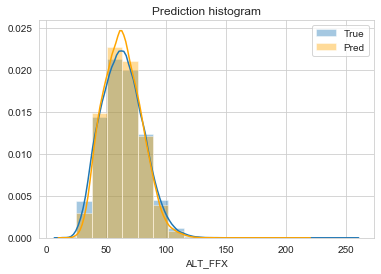

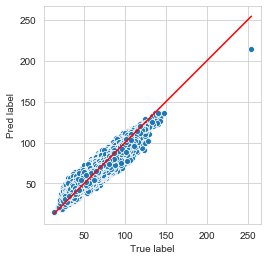

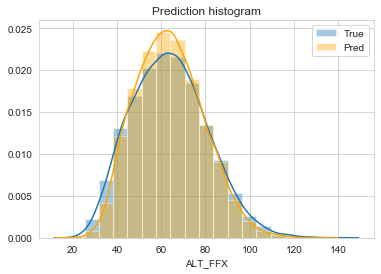

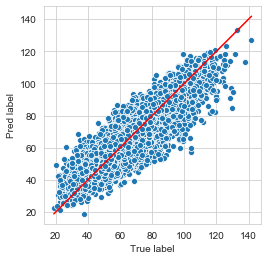

In [122]:
# Evaluate performance default classifier
print("--- Train set ---")
evaluate_regression(y_true= y_train, y_pred = clf.predict(X_train))
print("--- Test set ---")
evaluate_regression(y_true= y_test, y_pred = clf.predict(X_test))

(5, 90)

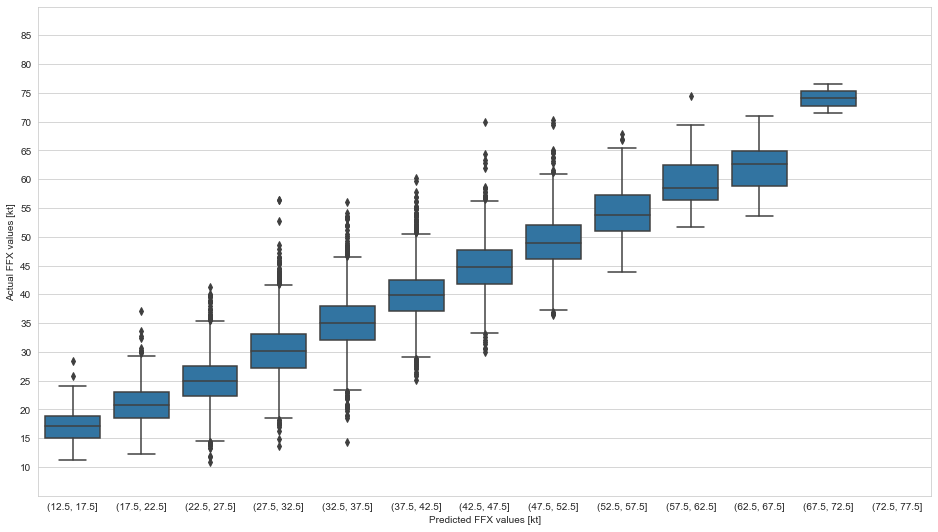

In [123]:
plt.figure(figsize=(16,9))
sns.boxplot(x=pd.cut(clf.predict(X_test)/1.852, bins=np.arange(12.5,80,5)), y=y_test/1.852, color="tab:blue")
plt.yticks(range(10,90,5))
plt.xlabel("Predicted FFX values [kt]")
plt.ylabel("Actual FFX values [kt]")
plt.ylim([5,90])

In [124]:
df_importances = pd.DataFrame({"features": final_features, "importance": clf.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True)
df_importances.head(20)

,features,importance
0,diff_ABO_Z850_PIO_Z850,0.145397
1,diff_ENG_Z850_PIO_Z850,0.087150
2,diff_GLA_SLP_SBO_SLP,0.034143
3,diff_HOE_Z850_PIO_Z850,0.013843
4,diff_PIO_Z850_STG_Z850,0.011365
5,diff_MVE_TT_VAD_TT,0.010194
6,diff_HOE_Z850_SBE_Z850,0.009252
7,diff_AND_TT_ENG_TT,0.008487
8,diff_SBO_SLP_VAD_SLP,0.008049
9,diff_AIG_TT_GUT_TT,0.007755


--- Train set ---
(MAE) Mean absolute error:  9.8395
(MSE) Mean squared error:  161.1989
(RMSE) Root mean squared error:  12.6964
(RMSLE) Root mean squared log error:  0.0429
(MedAE) Median absolute error:  7.9711
(R2) R2-score:  0.4545
(EV) Explained_variance:  0.4545
(CorrCoeff) Correlation Coefficient:  0.6742
--- Test set ---
(MAE) Mean absolute error:  9.961
(MSE) Mean squared error:  164.1121
(RMSE) Root mean squared error:  12.8106
(RMSLE) Root mean squared log error:  0.0437
(MedAE) Median absolute error:  8.0792
(R2) R2-score:  0.4384
(EV) Explained_variance:  0.4384
(CorrCoeff) Correlation Coefficient:  0.6623


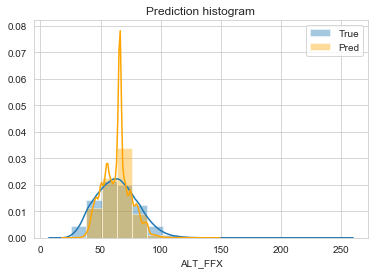

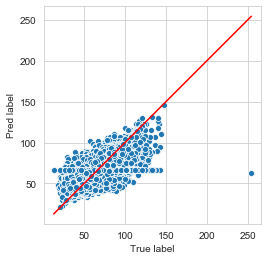

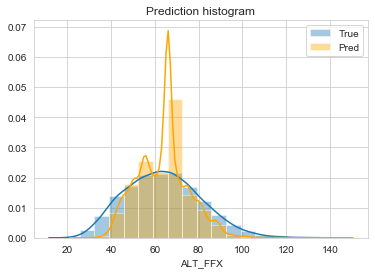

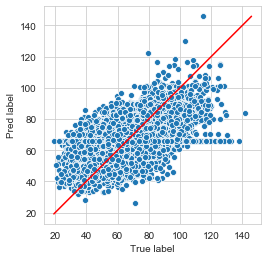

In [125]:
# Fit default classifier
clf.fit(X_train[["diff_ABO_Z850_PIO_Z850"]], y_train, verbose=1)
# Evaluate performance default classifier
print("--- Train set ---")
evaluate_regression(y_true= y_train, y_pred = clf.predict(X_train[["diff_ABO_Z850_PIO_Z850"]]))
print("--- Test set ---")
evaluate_regression(y_true= y_test, y_pred = clf.predict(X_test[["diff_ABO_Z850_PIO_Z850"]]))

In [126]:
df_strength_fe["diff_ABO_Z850_PIO_Z850"]

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
103313   -28.4
103314   -27.5
103315   -24.4
103316   -21.3
103317   -17.3
Name: diff_ABO_Z850_PIO_Z850, Length: 103318, dtype: float64

<Figure size 432x288 with 0 Axes>

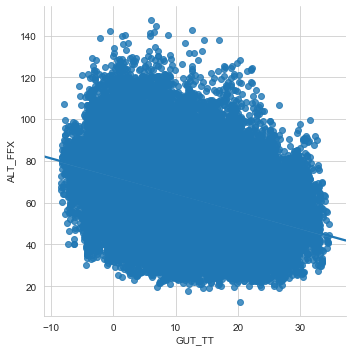

In [21]:
# Inspect single features manually
var = "GUT_TT"
# For numerical
plt.figure()
sns.lmplot(x=var, y=target, data=df_strength_fe) 

# For categorical
# plt.figure()
# sns.boxplot(x=var, y=target, data=df_train_processed)
# plt.figure()
# sns.barplot(x=var, y=target, data=df_train_processed) 

/home/chmony/Apps/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/chmony/Apps/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


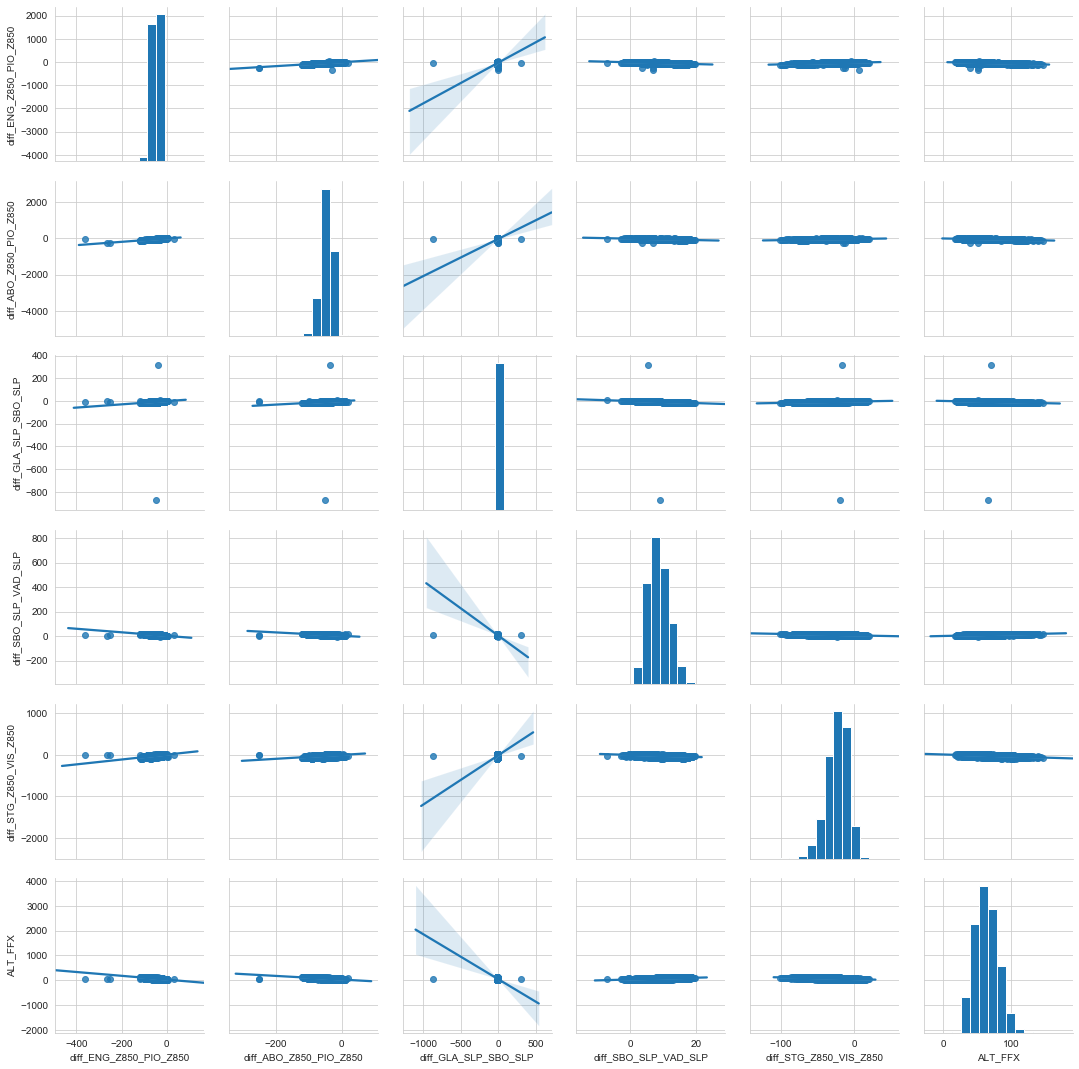

In [22]:
# Inspect pairplot of most important features
sns.pairplot(df_strength_fe[list(df_importances.iloc[0:5, 0]) + [target]], kind="reg")

In [23]:
# Inspect partial dependence plots
display = plot_partial_dependence(clf, 
                                  X_train.dropna(axis=0),
                                  percentiles=(0.1,0.9),
                                  features = list(df_importances.loc[0:8, "features"]), 
                                 grid_resolution=10)
display.figure_.subplots_adjust(hspace=0.5)
display.figure_.set_size_inches(16, 9)
#display.figure_.axes[1].set_ylim([0,1])

ValueError: Feature diff_ENG_Z850_PIO_Z850 not in feature_names